# 4.3. Random forest + features engineering

## Environment setup

### Install TGL package

In [79]:
import os

In [80]:
os.environ['PATH'] = "/Users/ivandonofrio/Workplace/Notebooks/venv/bin:" + os.environ['PATH']

In [81]:
%%sh
git clone git@github.com:donofiva/TemporalGraphLearning.git
cd TemporalGraphLearning
pip install .
cd ..
rm -r TemporalGraphLearning

Cloning into 'TemporalGraphLearning'...


Processing /Users/ivandonofrio/Workplace/Notebooks/TemporalGraphLearning
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for temporal_graph_learning: filename=temporal_graph_learning-0.0.1-py3-none-any.whl size=13162 sha256=b06fdd10a4394b3543b2e27c1ce40f8441493c3028c4a50bdf64c91135069c5a
  Stored in directory: /private/var/folders/qv/mvb8szpn0zgfn8vn02k7c24m0000gn/T/pip-ephem-wheel-cache-tpko3_n3/wheels/39/db/05/f395aacb8d67d0f880772d6a24131398880b7ba726b6f1820e
Successfully built temporal_graph_learning
  Attempting uninstall: temporal_graph_learning
    Found existing installation: tempo

### Install dependencies

In [82]:
!pip install numpy

In [83]:
!pip install scipy

In [84]:
!pip install pandas

In [85]:
!pip install matplotlib

In [86]:
!pip install seaborn

In [87]:
!pip install scikit-learn

### Define constants and configurations

In [88]:
INPUT_PATH = 'inputs'

## Dependencies

In [89]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
from temporal_graph_learning.abstraction.Dataset import Dataset
from temporal_graph_learning.abstraction.Timeseries import Timeseries
from temporal_graph_learning.charts.Plots import Plots
from temporal_graph_learning.charts.Plot import Plot
from temporal_graph_learning.charts.Histogram import Histogram
from temporal_graph_learning.charts.Lineplot import Lineplot
from temporal_graph_learning.charts.IdentityLine import IdentityLine
from temporal_graph_learning.charts.Heatmap import Heatmap
from temporal_graph_learning.charts.Scatterplot import Scatterplot
from temporal_graph_learning.charts.Text import Text
from temporal_graph_learning.charts.AutoCorrelation import AutoCorrelation
from temporal_graph_learning.io.FileManager import FileManager
from temporal_graph_learning.data.impute.LinearInterpolationImputer import LinearInterpolationImputer
from temporal_graph_learning.models.MultiTargetLinearRegression import MultiTargetLinearRegression

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [92]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

## Read data

In [93]:
timeseries = pd.read_csv('inputs/timeseries_outliers.csv')

In [94]:
timeseries = timeseries[timeseries.TURBINE == 1].reset_index(drop=True)

## Processing

In [95]:
timeseries = timeseries.dropna(ignore_index=True)

In [96]:
timeseries['PITCH_ANGLE_BLADES'] = timeseries[[
    'PITCH_ANGLE_FIRST_BLADE',
    'PITCH_ANGLE_SECOND_BLADE',
    'PITCH_ANGLE_THIRD_BLADE'
]].mean(axis=1)

In [97]:
timeseries['WIND_DIRECTION'] = np.cos(np.radians(timeseries['WIND_DIRECTION']))

In [98]:
timeseries = timeseries.drop(
    columns=[
        'TURBINE', 
        'DAY', 
        'TIMESLOT',
        'PITCH_ANGLE_FIRST_BLADE',
        'PITCH_ANGLE_SECOND_BLADE',
        'PITCH_ANGLE_THIRD_BLADE'
    ]
)

## Training

In [99]:
X = timeseries.drop(columns=['ACTIVE_POWER'])

In [100]:
y = timeseries['ACTIVE_POWER']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, shuffle=True)

In [102]:
pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures(2, interaction_only=True)),
    ('regressor', RandomForestRegressor(n_estimators=20, n_jobs=8))
])

In [103]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomial_features',
                 PolynomialFeatures(interaction_only=True)),
                ('regressor',
                 RandomForestRegressor(n_estimators=20, n_jobs=8))])

In [104]:
y_hat = pipeline.predict(X_test)

## Residuals plot

In [105]:
residual_scatterplot = Scatterplot(opacity=0.05)
identity_line = IdentityLine()

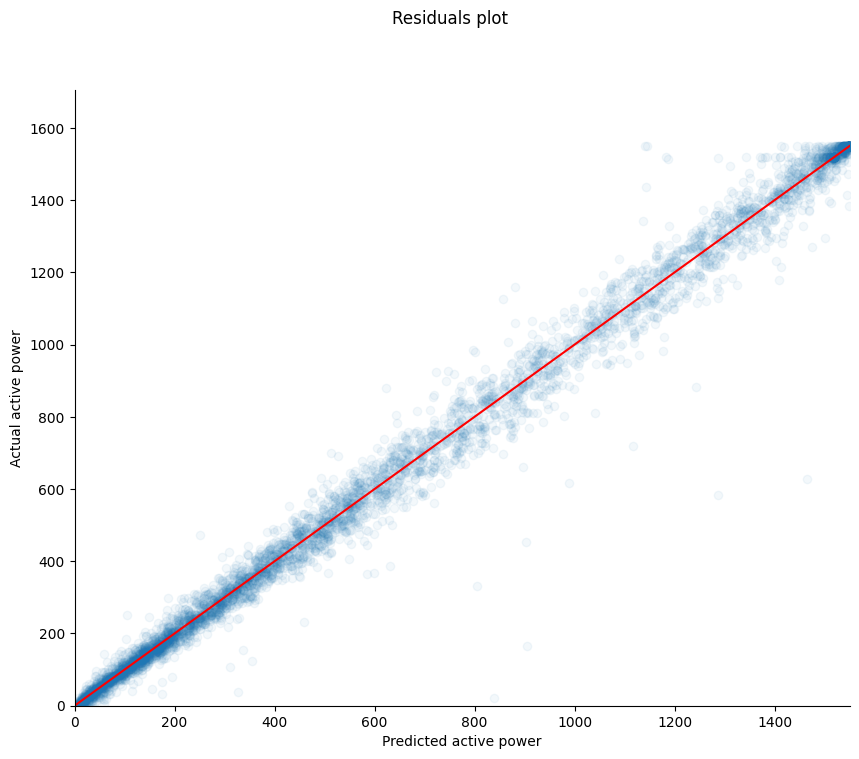

In [106]:
# Initialize plots
plots = Plots(1, 1, 10, 8)
plot = plots.get_plot_from_list_by_index(0)

# Draw scatterplot
identity_line.draw_on_plot(plot)
residual_scatterplot.draw_on_plot(
    y_hat,
    y_test.values,
    plot
)

# Configure plot
plot.toggle_top_and_right_border(False)
plot.set_x_axis_boundaries(y_hat.min(), y_hat.max())
plot.set_y_axis_boundaries(y_test.values.min(), y_test.values.max() * 1.1)
plot.set_axis_labels('Predicted active power', 'Actual active power')
plots.set_title('Residuals plot')

## Feature importance

In [107]:
feature_to_feature_importance = dict(
    zip(
        pipeline.named_steps['polynomial_features'].get_feature_names_out(X_train.columns),
        pipeline.named_steps['regressor'].feature_importances_
    )
)

In [108]:
feature_to_feature_importance = pd.DataFrame(
    feature_to_feature_importance.items(), 
    columns=['DIMENSION', 'WEIGHT']
)

feature_to_feature_importance.sort_values('WEIGHT', ignore_index=True)

,DIMENSION,WEIGHT
0,1,0.000000
1,REACTIVE_POWER,0.000191
2,NACELLE_DIRECTION,0.000202
3,WIND_DIRECTION NACELLE_DIRECTION,0.000254
4,REACTIVE_POWER PITCH_ANGLE_BLADES,0.000298
5,WIND_DIRECTION REACTIVE_POWER,0.000311
6,WIND_SPEED NACELLE_DIRECTION,0.000322
7,WIND_DIRECTION INTERNAL_TEMPERATURE,0.000359
8,EXTERNAL_TEMPERATURE,0.000385
9,INTERNAL_TEMPERATURE NACELLE_DIRECTION,0.000398


## Validation

In [109]:
cross_validation = cross_validate(
    pipeline,
    X,
    y,
    cv=KFold(shuffle=True),
    scoring=[
        'neg_mean_absolute_error',
        'neg_root_mean_squared_error',
        'r2'
    ]
)

In [110]:
pd.DataFrame(cross_validation)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2
0,2.163537,0.021408,-27.026284,-43.698200,0.992948
1,1.600793,0.016026,-26.784515,-44.487972,0.992673
2,1.512863,0.016117,-28.702134,-48.894650,0.991149
3,1.618978,0.014220,-27.540474,-51.020767,0.990601
4,1.734456,0.015851,-27.243349,-46.956023,0.991881
